# _Fermi_-LAT Crab Pulsar / Nebula Flux Ratio
This notebook studies the flux ratio of the Crab Pulsar and Nebula to find an energy threshold for the _Fermi_-LAT  dataset above which the Pulsar flux reduces to 10% of the Nebula flux.  

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import Table
from gammapy.spectrum import CrabSpectrum
from gammapy.spectrum.models import ExponentialCutoffPowerLaw3FGL

We use the multi-wavelength spectral points stored in this repository, to visualize the fluxes of the Pulsar and the Nebula. 

For the calculation of the flux ratio we use for the Nebula the model in Meyer et al. 2010 ([2010A&A...523A...2M](https://adsabs.harvard.edu/abs/2010A%26A...523A...2M)) implemented in `gammapy.spectrum.CrabSpectrum`:

In [2]:
nebula_meyer_spectrum = CrabSpectrum(reference="meyer")

For the Pulsar we use the spectral model in the $100\,\mathrm{MeV}-300\,\mathrm{GeV}$ range provided in the Fermi-LAT Third Source Catalog (3FGL, [2015ApJS..218...23A](http://adsabs.harvard.edu/abs/2015ApJS..218...23A)):

In [3]:
pulsar_3fgl_spectrum = ExponentialCutoffPowerLaw3FGL(
    index=2.045,
    amplitude=5.541e-10 * u.Unit("1 / (cm2 MeV s)"),
    reference=635.5 * u.MeV,
    ecut=8143.0 * u.MeV,
)

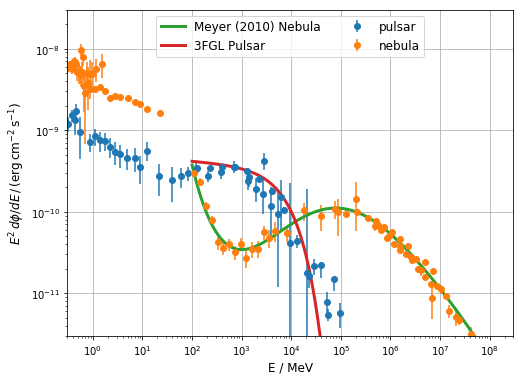

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot MWL flux points
table = Table.read("data/other/crab_mwl.fits.gz")

for component in ["pulsar", "nebula"]:
    t = table[table["component"] == component]
    x = t["energy"].data
    y = t["energy_flux"].data
    yerr_lo = t["energy_flux_err_lo"].data
    yerr_hi = t["energy_flux_err_hi"].data
    ax.errorbar(x, y, yerr=(yerr_lo, yerr_hi), fmt="o", label=component)

# plot SED model
energy = np.logspace(2, 8, 100) * u.MeV

flux = nebula_meyer_spectrum.model(energy)
energy_flux = (energy ** 2 * flux).to("erg cm^-2 s^-1")
ax.plot(energy.value, energy_flux.value, label="Meyer (2010) Nebula", lw=3)

pulsar_3fgl_spectrum.plot(
    [0.1, 300] * u.GeV,
    energy_power=2,
    flux_unit="erg-1 cm-2 s-1",
    energy_unit="MeV",
    lw=3,
    label="3FGL Pulsar",
    ax=ax,
)

ax.set_xlim((3e-1, 3e8))
ax.set_ylim((3e-12, 3e-8))
ax.set_xlabel("E / MeV", fontsize=12)
ax.set_ylabel(
    r"$E^2\,d\phi/dE\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$",
    fontsize=12,
)
ax.legend(loc="upper center", ncol=2, fontsize=12)
ax.grid()
ax.loglog();

The spectrum of the Pulsar (blue points, fitted by the 3FGL spectrum in red) dominates by one order of magnitude in energy flux the spectrum of the Nebula (orange points, fitted by the Meyer model in green) in the energy range $100$ to $10^4\,\mathrm{MeV}$. Above $10^4\,\mathrm{MeV}\,(10\,\mathrm{GeV})$ the Nebula flux dominates again.
We want to estimate the minimum energy above which the flux of the Pulsar is below 10% of the flux of theNebula.

## compute the 10% ratio of fluxes
We compute the ratio of the fluxes integrating from a varying energy threshold to $300\,\mathrm{GeV}$.

In [5]:
EMIN, EMAX = [1, 300] * u.GeV

emins = np.logspace(np.log10(EMIN.value), np.log10(EMAX.value), 30) * u.GeV
emaxs = EMAX * np.ones(len(emins))

In [6]:
# Compute integral fluxes above various minimal energies
flux_int_crab_pulsar = pulsar_3fgl_spectrum.integral(
    emin=emins, emax=emaxs, intervals=True
)
flux_int_crab_nebula = nebula_meyer_spectrum.model.integral(
    emin=emins, emax=emaxs, intervals=True
)

# Compute integral flux ratio
flux_int_ratio = (flux_int_crab_pulsar / flux_int_crab_nebula).to("")

We find the energy threshold, where the contamination by the pulsar drops below 10%:

In [7]:
ratio_max = 0.1
e_thresh = emins[flux_int_ratio < ratio_max][0]
print("{:.2f}".format(e_thresh))

28.32 GeV


And finally plot the flux ratio against lower energy threshold:

(0.0001, 10.0)

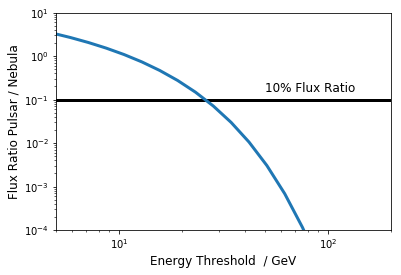

In [8]:
plt.plot(emins, flux_int_ratio, lw=3)
plt.loglog()
plt.xlabel("Energy Threshold  / GeV", fontsize=12)
plt.ylabel("Flux Ratio Pulsar / Nebula", fontsize=12)
plt.hlines(ratio_max, 0.1, 1e3, lw=3)
plt.text(
    x=0.5e2,
    y=(1.5 * ratio_max),
    s="{:.0%} Flux Ratio".format(ratio_max),
    fontsize=12,
)
plt.xlim(5, 2e2)
plt.ylim(1e-4, 1e1)

We will assume $30\,\mathrm{GeV}$ as a threshold for the _Fermi_-LAT dataset in the joint analysis.